<a href="https://colab.research.google.com/github/AbiXnash/Forecasting-Net-Prophet/blob/main/forecasting_net_prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting Net Prophet

In this project I am a growth analyst at [MercadoLibre](http://investor.mercadolibre.com/investor-relations). With over 200 million users, MercadoLibre is the most popular e-commerce site in Latin America. I've been tasked with analyzing the company's financial and user data in clever ways to make the company grow. So, I want to find out if the ability to predict search traffic can translate into the ability to successfully trade the stock.

## Overview:

* Step 1: Find unusual patterns in hourly Google search traffic

* Step 2: Mine the search traffic data for seasonality

* Step 3: Relate the search traffic to stock price patterns

* Step 4: Create a time series model with Prophet

* Step 5 (optional): Forecast revenue by using time series models


## Install and import the required libraries and dependencies

In [ ]:
# Install the required libraries
!pip install pystan
!pip install fbprophet
!pip install hvplot
!pip install holoviews

In [ ]:
# Import the required libraries and dependencies
import pandas as pd
import holoviews as hv
from fbprophet import Prophet
import hvplot.pandas
import datetime as dt
import numpy as np
%matplotlib inline

## Step 1: Find Unusual Patterns in Hourly Google Search Traffic

The data science manager asks if the Google search traffic for the company links to any financial events at the company. Or, does the search traffic data just present random noise?



#### Step 1: Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.)

In [ ]:
# Upload the "google_hourly_search_trends.csv" file into Colab, then store in a Pandas DataFrame

from google.colab import files
uploaded = files.upload()

Saving google_hourly_search_trends.csv to google_hourly_search_trends (1).csv


In [ ]:
# Read the csv file into a dataframe
df_mercado_trends = pd.read_csv('google_hourly_search_trends.csv')
# Set the "Date" column as the Datetime Index.
df_mercado_trends['Date'] = pd.to_datetime(
    df_mercado_trends['Date'],
    infer_datetime_format = True
)
# Set 'Date' as index of the dataframe
df_mercado_trends = df_mercado_trends.set_index('Date')


# Review the first and last five rows of the DataFrame
display(df_mercado_trends.head())
display(df_mercado_trends.tail())

,Search Trends
Date,
2016-06-01 00:00:00,97
2016-06-01 01:00:00,92
2016-06-01 02:00:00,76
2016-06-01 03:00:00,60
2016-06-01 04:00:00,38


,Search Trends
Date,
2020-09-07 20:00:00,71
2020-09-07 21:00:00,83
2020-09-07 22:00:00,96
2020-09-07 23:00:00,97
2020-09-08 00:00:00,96


In [ ]:
# Review the data types of the DataFrame using the info function
df_mercado_trends.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37106 entries, 2016-06-01 00:00:00 to 2020-09-08 00:00:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Search Trends  37106 non-null  int64
dtypes: int64(1)
memory usage: 579.8 KB


In [ ]:
# Holoviews extension to render hvPlots in Colab
hv.extension('bokeh')

# Slice the DataFrame to just the month of May 2020
df_may_2020 = df_mercado_trends.loc['2020-05']

# Use hvPlot to visualize the data for May 2020
df_may_2020.hvplot()


#### Step 2: Calculate the total search traffic for the month, and then compare the value to the monthly median across all months to see if Google search traffic increase during the month that MercadoLibre released its financial results.

In [ ]:
# Calculate the sum of the total search traffic for May 2020
traffic_may_2020 = df_may_2020.sum()

# View the traffic_may_2020 value
traffic_may_2020


Search Trends    38181
dtype: int64

In [ ]:
# Calcluate the monhtly median search traffic across all months
# Group the DataFrame by index year and then index month, chain the sum and then the median functions
median_monthly_traffic = df_mercado_trends.groupby(by=[df_mercado_trends.index.year,df_mercado_trends.index.month]).sum().median()

# View the median_monthly_traffic value
median_monthly_traffic


Search Trends    35172.5
dtype: float64

In [ ]:
# Compare the seach traffic for the month of May 2020 to the overall monthly median value
traffic_may_2020 / median_monthly_traffic


Search Trends    1.085536
dtype: float64

##### Insights:

During May 2020, the search traffic was 38181 in total, which is 3837 times more or 8% more than the overall montly median search traffic

## Step 2: Mine the Search Traffic Data for Seasonality

Marketing realizes that they can use the hourly search data, too. If they can track and predict interest in the company and its platform for any time of day, they can focus their marketing efforts around the times that have the most traffic. This will get a greater return on investment (ROI) from their marketing budget.

To that end, I want to mine the search traffic data for predictable seasonal patterns of interest in the company.

#### Step 1: Group the hourly search data to plot the average traffic by the day of the week.

In [ ]:
# Holoviews extension to render hvPlots in Colab
hv.extension('bokeh')

# Group the hourly search data to plot (use hvPlot) the average traffic by the day of week
df_mercado_trends.groupby(df_mercado_trends.index.dayofweek).mean().hvplot()


#### Step 2: Using hvPlot, visualize this traffic as a heatmap, referencing the `index.hour` as the x-axis and the `index.dayofweek` as the y-axis.

In [ ]:
# Holoviews extension to render hvPlots in Colab
hv.extension('bokeh')

# Use hvPlot to visualize the hour of the day and day of week search traffic as a heatmap.
df_mercado_trends.hvplot.heatmap(
    x='index.hour',
    y='index.dayofweek',
    C='Search Trends',
    cmap='blues'
).aggregate(function=np.mean)


##### Insights:

During 5-10 am of every day of the week, low and none search traffic were detected. Heavy search traffic happens during 21-2 hours of the day. It seems people search the most during Sun.-Thu. between 21-2 hours of the day.

#### Step 3: Group the search data by the week of the year.

In [ ]:
# Holoviews extension to render hvPlots in Colab
hv.extension('bokeh')

# Group the hourly search data to plot (use hvPlot) the average traffic by the week of the year
df_mercado_trends.groupby(df_mercado_trends.index.weekofyear).mean().hvplot()

##### Insights:

During winter hodilday, search traffic tend to increase comparing to the previous season. It picked up from 45 and peaked at 49 in week 51.

## Step 3: Relate the Search Traffic to Stock Price Patterns

The finance group at the company want to know if any relationship between the search data and the company stock price exists.

#### Step 1: Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

In [ ]:
# Upload the "mercado_stock_price.csv" file into Colab, then store in a Pandas DataFrame
# Set the "date" column as the Datetime Index.
from google.colab import files
uploaded = files.upload()
# Read the csv file into dataframe
df_mercado_stock = pd.read_csv('mercado_stock_price.csv')
df_mercado_stock['date'] = pd.to_datetime(
    df_mercado_stock['date'],
    infer_datetime_format = True
)
# Set 'date' as index of the dataframe
df_mercado_stock = df_mercado_stock.set_index('date')


# View the first and last five rows of the DataFrame
display(df_mercado_stock.head())
display(df_mercado_stock.tail())

Saving mercado_stock_price.csv to mercado_stock_price.csv


,close
date,
2015-01-02 09:00:00,127.67
2015-01-02 10:00:00,125.44
2015-01-02 11:00:00,125.57
2015-01-02 12:00:00,125.40
2015-01-02 13:00:00,125.17


,close
date,
2020-07-31 11:00:00,1105.780
2020-07-31 12:00:00,1087.925
2020-07-31 13:00:00,1095.800
2020-07-31 14:00:00,1110.650
2020-07-31 15:00:00,1122.510


In [ ]:
# Holoviews extension to render hvPlots in Colab
hv.extension('bokeh')

# Use hvPlot to visualize the closing price of the df_mercado_stock DataFrame
df_mercado_stock['close'].hvplot(
    title="Historial Mercado Closing Prices",
    figsize=[20, 10]
)

In [ ]:
# Concatenate the df_mercado_stock DataFrame with the df_mercado_trends DataFrame
# Concatenate the DataFrame by columns (axis=1), and drop rows with only one column of data
mercado_stock_trends_df = pd.concat([df_mercado_stock, df_mercado_trends], axis=1).dropna()

# View the first and last five rows of the DataFrame
display(mercado_stock_trends_df.head())
display(mercado_stock_trends_df.tail())

,close,Search Trends
2016-06-01 09:00:00,135.16,6.0
2016-06-01 10:00:00,136.63,12.0
2016-06-01 11:00:00,136.56,22.0
2016-06-01 12:00:00,136.42,33.0
2016-06-01 13:00:00,136.10,40.0


,close,Search Trends
2020-07-31 11:00:00,1105.780,20.0
2020-07-31 12:00:00,1087.925,32.0
2020-07-31 13:00:00,1095.800,41.0
2020-07-31 14:00:00,1110.650,47.0
2020-07-31 15:00:00,1122.510,53.0


#### Step 2: Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then use hvPlot to plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

In [ ]:
# For the combined dataframe, slice to just the first half of 2020 (2020-01 through 2020-06)
first_half_2020 = mercado_stock_trends_df.loc['2020-01':'2020-06']

# View the first and last five rows of first_half_2020 DataFrame
display(first_half_2020.head())
display(first_half_2020.tail())

,close,Search Trends
2020-01-02 09:00:00,601.085,9.0
2020-01-02 10:00:00,601.290,14.0
2020-01-02 11:00:00,615.410,25.0
2020-01-02 12:00:00,611.400,37.0
2020-01-02 13:00:00,611.830,50.0


,close,Search Trends
2020-06-30 11:00:00,976.17,17.0
2020-06-30 12:00:00,977.50,27.0
2020-06-30 13:00:00,973.23,37.0
2020-06-30 14:00:00,976.50,45.0
2020-06-30 15:00:00,984.93,51.0


In [ ]:
# Holoviews extension to render hvPlots in Colab
hv.extension('bokeh')

# Use hvPlot to visualize the close and Search Trends data
# Plot each column on a separate axes using the following syntax
# `hvplot(shared_axes=False, subplots=True).cols(1)`
first_half_2020.hvplot(shared_axes=False, subplots=True).cols(1)

##### Insights:

Both time series visualization confirmed the narrative. The stock price plummet during march and at the same time the search trend dropped dramatically. Later on in May, both stock price and search traffic surged due to the e-commerce.

#### Step 3: Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

* “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

* “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis


In [ ]:
# Create a new column in the mercado_stock_trends_df DataFrame called Lagged Search Trends
# This column should shift the Search Trends information by one hour
mercado_stock_trends_df['Lagged Search Trends'] = mercado_stock_trends_df['Search Trends'].shift(1)

In [ ]:
# Create a new column in the mercado_stock_trends_df DataFrame called Stock Volatility
# This column should calculate the standard deviation of the closing stock price return data over a 4 period rolling window
mercado_stock_trends_df['Stock Volatility'] = mercado_stock_trends_df['close'].pct_change().rolling(window=4).std()


In [ ]:
# Holoviews extension to render hvPlots in Colab
hv.extension('bokeh')

# Use hvPlot to visualize the stock volatility
mercado_stock_trends_df['Stock Volatility'].hvplot()


In [ ]:
# Create a new column in the mercado_stock_trends_df DataFrame called Hourly Stock Return
# This column should calculate hourly return percentage of the closing price
mercado_stock_trends_df['Hourly Stock Return'] = mercado_stock_trends_df['close'].pct_change()


In [ ]:
# View the first and last five rows of the mercado_stock_trends_df DataFrame
display(mercado_stock_trends_df.head())
display(mercado_stock_trends_df.tail())

,close,Search Trends,Lagged Search Trends,Stock Volatility,Hourly Stock Return
2016-06-01 09:00:00,135.16,6.0,NaN,NaN,NaN
2016-06-01 10:00:00,136.63,12.0,6.0,NaN,0.010876
2016-06-01 11:00:00,136.56,22.0,12.0,NaN,-0.000512
2016-06-01 12:00:00,136.42,33.0,22.0,NaN,-0.001025
2016-06-01 13:00:00,136.10,40.0,33.0,0.006134,-0.002346


,close,Search Trends,Lagged Search Trends,Stock Volatility,Hourly Stock Return
2020-07-31 11:00:00,1105.780,20.0,11.0,0.012837,0.006380
2020-07-31 12:00:00,1087.925,32.0,20.0,0.013549,-0.016147
2020-07-31 13:00:00,1095.800,41.0,32.0,0.013295,0.007239
2020-07-31 14:00:00,1110.650,47.0,41.0,0.013001,0.013552
2020-07-31 15:00:00,1122.510,53.0,47.0,0.013566,0.010678


#### Step 4: Review the time series correlation.

In [ ]:
# Construct correlation table of Stock Volatility, Lagged Search Trends, and Hourly Stock Return
mercado_stock_trends_df[['Stock Volatility','Lagged Search Trends','Hourly Stock Return']].corr()


,Stock Volatility,Lagged Search Trends,Hourly Stock Return
Stock Volatility,1.000000,-0.148938,0.061424
Lagged Search Trends,-0.148938,1.000000,0.017929
Hourly Stock Return,0.061424,0.017929,1.000000


##### Insights:


There is no predictable relationship exists between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns since correlation calculated ratios are not strong enough to indicate a trend.

## Step 4: Create a Time Series Model with Prophet


#### Step 1: Set up the Google search data for a Prophet forecasting model.

In [ ]:
# Using the df_mercado_trends DataFrame, reset the index so the date information is no longer the index
mercado_prophet_df = df_mercado_trends.reset_index()

# Label the columns ds and y so that the syntax is recognized by Prophet
mercado_prophet_df.columns = ['ds','y']

# Drop an NaN values from the prophet_df DataFrame
mercado_prophet_df = mercado_prophet_df.dropna()

# View the first and last five rows of the mercado_prophet_df DataFrame
display(mercado_prophet_df.head())
display(mercado_prophet_df.tail())

,ds,y
0,2016-06-01 00:00:00,97
1,2016-06-01 01:00:00,92
2,2016-06-01 02:00:00,76
3,2016-06-01 03:00:00,60
4,2016-06-01 04:00:00,38


,ds,y
37101,2020-09-07 20:00:00,71
37102,2020-09-07 21:00:00,83
37103,2020-09-07 22:00:00,96
37104,2020-09-07 23:00:00,97
37105,2020-09-08 00:00:00,96


In [ ]:
# Call the Prophet function, store as an object
model_mercado_trends = Prophet()


In [ ]:
# Fit the time-series model.
model_mercado_trends.fit(mercado_prophet_df)


In [ ]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 2000 hours (approx 80 days)
future_mercado_trends = model_mercado_trends.make_future_dataframe(periods = 2000, freq = 'H')

# View the last five rows of the future_mercado_trends DataFrame
future_mercado_trends.tail()


,ds
39101,2020-11-30 04:00:00
39102,2020-11-30 05:00:00
39103,2020-11-30 06:00:00
39104,2020-11-30 07:00:00
39105,2020-11-30 08:00:00


In [ ]:
# Make the predictions for the trend data using the future_mercado_trends DataFrame
forecast_mercado_trends = model_mercado_trends.predict(future_mercado_trends)

# Display the first five rows of the forecast_mercado_trends DataFrame
forecast_mercado_trends.head()


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-06-01 00:00:00,44.437254,81.182638,97.378383,44.437254,44.437254,45.198724,45.198724,45.198724,41.452626,...,1.860528,1.860528,1.860528,1.885569,1.885569,1.885569,0.0,0.0,0.0,89.635978
1,2016-06-01 01:00:00,44.438181,77.901033,94.828586,44.438181,44.438181,41.644504,41.644504,41.644504,37.943462,...,1.810432,1.810432,1.810432,1.890611,1.890611,1.890611,0.0,0.0,0.0,86.082685
2,2016-06-01 02:00:00,44.439108,67.715292,84.164777,44.439108,44.439108,31.321010,31.321010,31.321010,27.656545,...,1.768844,1.768844,1.768844,1.895621,1.895621,1.895621,0.0,0.0,0.0,75.760118
3,2016-06-01 03:00:00,44.440034,52.690782,68.985041,44.440034,44.440034,16.053788,16.053788,16.053788,12.417331,...,1.735858,1.735858,1.735858,1.900600,1.900600,1.900600,0.0,0.0,0.0,60.493823
4,2016-06-01 04:00:00,44.440961,34.285297,51.990704,44.440961,44.440961,-1.061098,-1.061098,-1.061098,-4.678073,...,1.711428,1.711428,1.711428,1.905547,1.905547,1.905547,0.0,0.0,0.0,43.379863


#### Step 2: Plot the forecast.

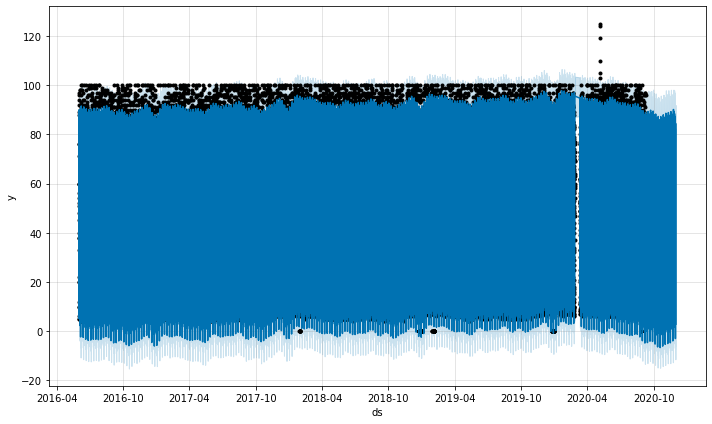

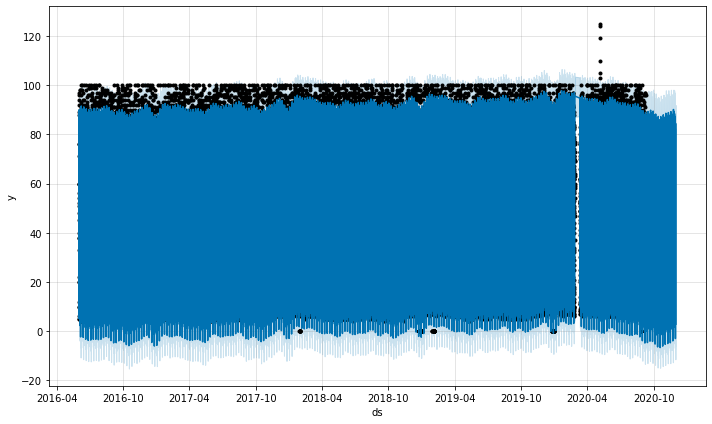

In [ ]:
# Plot the Prophet predictions for the Mercado trends data
model_mercado_trends.plot(forecast_mercado_trends)

##### Insights:

The forecast indicates a decrease of the popularity of MercadoLibre.


#### Step 3: Plot the individual time series components of the model.


In [ ]:
# Set the index in the forecast_mercado_trends DataFrame to the ds datetime column
forecast_mercado_trends = forecast_mercado_trends.set_index('ds')

# View the only the yhat,yhat_lower and yhat_upper columns from the DataFrame
forecast_mercado_trends[['yhat','yhat_lower','yhat_upper']]


,yhat,yhat_lower,yhat_upper
ds,,,
2016-06-01 00:00:00,89.635978,81.182638,97.378383
2016-06-01 01:00:00,86.082685,77.901033,94.828586
2016-06-01 02:00:00,75.760118,67.715292,84.164777
2016-06-01 03:00:00,60.493823,52.690782,68.985041
2016-06-01 04:00:00,43.379863,34.285297,51.990704
...,...,...,...
2020-11-30 04:00:00,39.730796,31.318896,48.835366
2020-11-30 05:00:00,24.259673,15.961222,32.766783
2020-11-30 06:00:00,12.294015,4.477503,21.225958


In [ ]:
# Holoviews extension to render hvPlots in Colab
hv.extension('bokeh')

# From the forecast_mercado_trends DataFrame, use hvPlot to visualize
#  the yhat, yhat_lower, and yhat_upper columns over the last 2000 hours
forecast_mercado_trends[['yhat','yhat_lower','yhat_upper']].iloc[-2000:,:].hvplot()


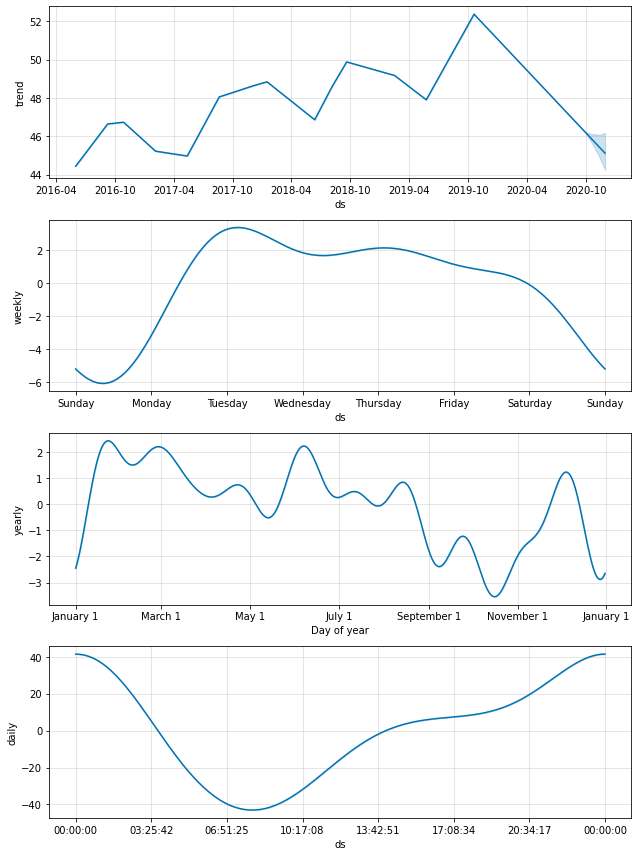

In [ ]:
# Reset the index in the forecast_mercado_trends DataFrame
forecast_mercado_trends = forecast_mercado_trends.reset_index()

# Use the plot_components function to visualize the forecast results
# for the forecast_canada DataFrame
figures_mercado_trends = model_mercado_trends.plot_components(forecast_mercado_trends)


##### Insights:

Midnight or 00:00 shows the greatest popularity.

Tuesday has the highest search traffic.

October shows almost -4 in search traffic, which is the lowest in the calendar year.


## Step 5: Forecast Revenue by Using Time Series Models

#### Step 1: Read in the daily historical sales (revenue) figures, and then apply a Prophet model to the data.

In [ ]:
# Upload the "mercado_daily_revenue.csv" file into Colab, then store in a Pandas DataFrame
# Set the "date" column as the DatetimeIndex
# Sales are quoted in millions of US dollars
from google.colab import files
uploaded = files.upload()
# Read the csv file into dataframe
df_mercado_sales = pd.read_csv(
    'mercado_daily_revenue.csv')
df_mercado_sales['date'] = pd.to_datetime(
    df_mercado_sales['date'],
    infer_datetime_format = True
)
# Set 'date' as index of the dataframe
df_mercado_sales = df_mercado_sales.set_index('date')
# Review the DataFrame
display(df_mercado_sales.head())
display(df_mercado_sales.tail())


Saving mercado_daily_revenue.csv to mercado_daily_revenue (2).csv


,Daily Sales
date,
2019-01-01,0.626452
2019-01-02,1.301069
2019-01-03,1.751689
2019-01-04,3.256294
2019-01-05,3.732920


,Daily Sales
date,
2020-05-10,17.467814
2020-05-11,17.537152
2020-05-12,18.031773
2020-05-13,19.165315
2020-05-14,20.246570


In [ ]:
# Holoviews extension to render hvPlots in Colab
hv.extension('bokeh')

# Use hvPlot to visualize the daily sales figures
df_mercado_sales.hvplot()


In [ ]:
# Apply a Facebook Prophet model to the data.

# Set up the dataframe in the neccessary format:
# Reset the index so that date becomes a column in the DataFrame
mercado_sales_prophet_df = df_mercado_sales.reset_index()

# Adjust the columns names to the Prophet syntax
mercado_sales_prophet_df.columns = ['ds','y']

# Visualize the DataFrame
mercado_sales_prophet_df


,ds,y
0,2019-01-01,0.626452
1,2019-01-02,1.301069
2,2019-01-03,1.751689
3,2019-01-04,3.256294
4,2019-01-05,3.732920
...,...,...
495,2020-05-10,17.467814
496,2020-05-11,17.537152
497,2020-05-12,18.031773
498,2020-05-13,19.165315


In [ ]:
# Create the model
mercado_sales_prophet_model = Prophet()

# Fit the model
mercado_sales_prophet_model.fit(mercado_sales_prophet_df)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# Predict sales for 90 days (1 quarter) out into the future.

# Start by making a future dataframe
mercado_sales_prophet_future = mercado_sales_prophet_model.make_future_dataframe(periods = 90, freq = 'D')

# Display the last five rows of the future DataFrame
mercado_sales_prophet_future.tail()


,ds
585,2020-08-08
586,2020-08-09
587,2020-08-10
588,2020-08-11
589,2020-08-12


In [ ]:
# Make predictions for the sales each day over the next quarter
mercado_sales_prophet_forecast = mercado_sales_prophet_model.predict(mercado_sales_prophet_future)

# Display the first 5 rows of the resulting DataFrame
mercado_sales_prophet_forecast.head()


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-01,0.133067,-1.794511,2.000028,0.133067,0.133067,0.063730,0.063730,0.063730,0.063730,0.063730,0.063730,0.0,0.0,0.0,0.196797
1,2019-01-02,0.172247,-1.654304,2.176600,0.172247,0.172247,0.082772,0.082772,0.082772,0.082772,0.082772,0.082772,0.0,0.0,0.0,0.255019
2,2019-01-03,0.211428,-1.648737,2.071667,0.211428,0.211428,0.019580,0.019580,0.019580,0.019580,0.019580,0.019580,0.0,0.0,0.0,0.231008
3,2019-01-04,0.250609,-1.767988,2.050743,0.250609,0.250609,-0.057997,-0.057997,-0.057997,-0.057997,-0.057997,-0.057997,0.0,0.0,0.0,0.192611
4,2019-01-05,0.289789,-1.822511,1.981683,0.289789,0.289789,-0.123972,-0.123972,-0.123972,-0.123972,-0.123972,-0.123972,0.0,0.0,0.0,0.165817


#### Step 2: Interpret the model output to identify any seasonal patterns in the company's revenue.

##### Insights:

Wednesdays are peak revenue days.

#### Step 3: Produce a sales forecast for the finance group.

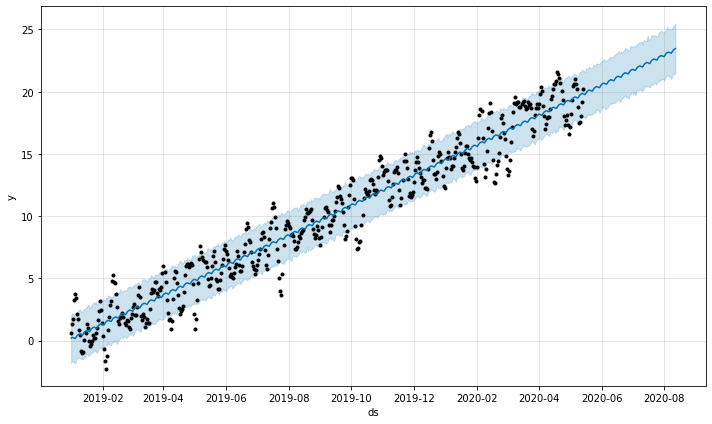

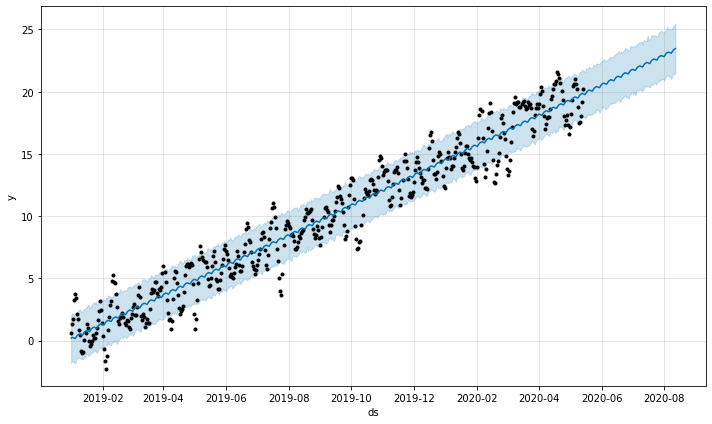

In [ ]:
# Plot the predictions for the Mercado sales
mercado_sales_prophet_model.plot(mercado_sales_prophet_forecast)


In [ ]:
# For the mercado_sales_prophet_forecast DataFrame, set the ds column as the DataFrame Index
mercado_sales_prophet_forecast = mercado_sales_prophet_forecast.set_index('ds')

# Display the first and last five rows of the DataFrame
display(mercado_sales_prophet_forecast.head())
display(mercado_sales_prophet_forecast.tail())


,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,
2019-01-01,0.133067,-1.794511,2.000028,0.133067,0.133067,0.063730,0.063730,0.063730,0.063730,0.063730,0.063730,0.0,0.0,0.0,0.196797
2019-01-02,0.172247,-1.654304,2.176600,0.172247,0.172247,0.082772,0.082772,0.082772,0.082772,0.082772,0.082772,0.0,0.0,0.0,0.255019
2019-01-03,0.211428,-1.648737,2.071667,0.211428,0.211428,0.019580,0.019580,0.019580,0.019580,0.019580,0.019580,0.0,0.0,0.0,0.231008
2019-01-04,0.250609,-1.767988,2.050743,0.250609,0.250609,-0.057997,-0.057997,-0.057997,-0.057997,-0.057997,-0.057997,0.0,0.0,0.0,0.192611
2019-01-05,0.289789,-1.822511,1.981683,0.289789,0.289789,-0.123972,-0.123972,-0.123972,-0.123972,-0.123972,-0.123972,0.0,0.0,0.0,0.165817


,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,
2020-08-08,23.219712,21.013246,24.922512,23.216725,23.222370,-0.123972,-0.123972,-0.123972,-0.123972,-0.123972,-0.123972,0.0,0.0,0.0,23.095741
2020-08-09,23.259320,21.332764,25.125075,23.256282,23.262040,-0.034153,-0.034153,-0.034153,-0.034153,-0.034153,-0.034153,0.0,0.0,0.0,23.225168
2020-08-10,23.298928,21.447385,25.242251,23.295815,23.301715,0.050039,0.050039,0.050039,0.050039,0.050039,0.050039,0.0,0.0,0.0,23.348968
2020-08-11,23.338536,21.380665,25.361535,23.335358,23.341383,0.063730,0.063730,0.063730,0.063730,0.063730,0.063730,0.0,0.0,0.0,23.402267
2020-08-12,23.378144,21.628433,25.469291,23.374926,23.381049,0.082772,0.082772,0.082772,0.082772,0.082772,0.082772,0.0,0.0,0.0,23.460916


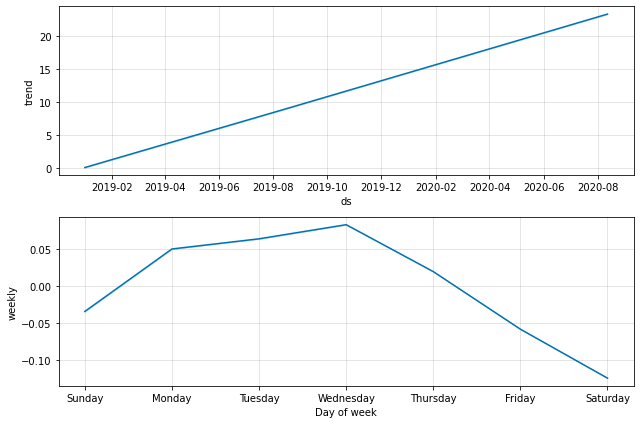

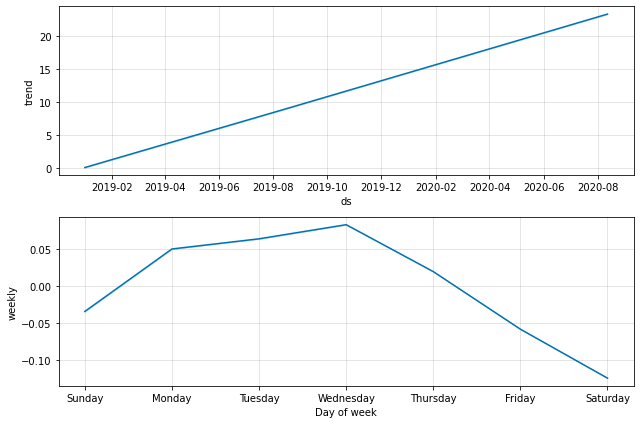

In [ ]:
# Reset index column of mercado_sales_prophet_forcast dataframe
mercado_sales_prophet_forecast = mercado_sales_prophet_forecast.reset_index()
# Use the plot_components function to analyze seasonal patterns in the company's revenue
mercado_sales_prophet_model.plot_components(mercado_sales_prophet_forecast)


In [ ]:
# Produce a sales forecast for the finance division
# giving them a number for expected total sales next quarter.
# Set ds as the index column
mercado_sales_prophet_forecast = mercado_sales_prophet_forecast.set_index('ds')
# Provide best case (yhat_upper), worst case (yhat_lower), and most likely (yhat) scenarios.
mercado_sales_forecast_quarter = mercado_sales_prophet_forecast [['yhat','yhat_upper','yhat_lower']]
# Create a forecast_quarter Dataframe for the period 2020-05-01 to 2020-07-30
# The DataFrame should include the columns yhat_upper, yhat_lower, and yhat
mercado_sales_forecast_quarter = mercado_sales_forecast_quarter.loc['2020-05-01':'2020-07-30']

# Update the column names for the forecast_quarter DataFrame
# to match what the finance division is looking for
mercado_sales_forecast_quarter = mercado_sales_forecast_quarter.rename(columns = {'yhat': 'most likely', 'yhat_upper': 'best case', 'yhat_lower': 'worst case'})

# Review the last five rows of the DataFrame
mercado_sales_forecast_quarter.tail()


,most likely,best case,worst case
ds,,,
2020-07-26,22.670657,24.512546,20.815669
2020-07-27,22.794457,24.775074,20.899833
2020-07-28,22.847756,24.814342,20.850528
2020-07-29,22.906405,24.911763,21.028654
2020-07-30,22.882822,24.853910,20.968651


In [ ]:
# Displayed the summed values for all the rows in the forecast_quarter DataFrame
mercado_sales_forecast_quarter.sum()


most likely    1918.360539
best case      2090.288504
worst case     1745.294417
dtype: float64

The most likely total sales amount is 1918 in the next quarter. While, the best case is that total sales will reach 2090 and the worst case it will be around 1745 level.